# Train Model For Fault Detection

En este laboratorio nos enfocaremos en como crear un modelo basado en machine learning para la detección de fallas en paneles solares. Para ello, nos enfocamos en la detección de 4 escenarios distintos, el escenario sin falla, fallo por sombreado parcial, fallo por grieta y fallo por polvo. Al terminar de entrenar el modelo de detección de fallas, procederemos a utilizar el modelo entrenado en una raspberry pi para experimentar con su desempeño. El modelo a implementar funciona de la siguiente manera:

1. En primer lugar, se utiliza segmentación semántica para identificar la ubicación de paneles en una imágen. La segmentación semántica es un algoritmo de deep learning que asocia una etiqueta o categoría a cada píxel presente en una imagen. Un ejemplo de ello se puede apreciar a continuación:

![picture](https://drive.google.com/uc?export=view&id=1TQ7X-aFEHBRa1zOkClP4T-ke55cxa6_R)

  Para realizar la segmentación semántica, utilizamos una arquitectura llamada U-net. Esta arquitectura se puede apreciar en la siguiente imagen. Para este laboratorio en particular, no entrenaremos la red U-net y utilizaremos un modelo ya previamente entrenado en la raspberry pi. Por tanto, asumiremos que esta primera red ya fue entrenada.

![picture](https://drive.google.com/uc?export=view&id=1-7dKWDuHsKMYV5FVv4wEtIUGES1RxKGq)


2. Después la imagen obtenida por medio de la segmentación es multiplicada por la imagen en particular que estamos tratando de clasificar, para así poder eliminar aquello en la imagen que no es de interes para la clasificación. Ejemplos de estas máscaras para las diferentes clases que se buscan clasificar se se muestran a continuación:
![image-2.png](https://drive.google.com/uc?export=view&id=1VcdD_-lICmizF5o84KlCF34-2L9vrSEj)

3. Por último, las imágenes multiplicadas por sus respectivas máscaras son utilizadas para entrenar un pre-trained model llamado VGG-16. Esto se puede ilustrar con la siguiente imágen:
![image-6.png](https://drive.google.com/uc?export=view&id=1yZZKHTOS7v3xx4Wic44E7PoEb7oeK3EN)

Primero se deben importar algunas librerias que nos serán de utilidad. TensorFlow es una plataforma de código abierto de extremo a extremo para deep learning o aprendizaje profundo. Permite implementar redes neuronales, convolucionales, diferentes funciones de activación, etc. Con esta plataforma nos encargaremos de importar el modelo VGG16 e implementar las diferentes redes necesarias. A su vez se importan librerias como matplotlib.pyplot para visualizar las imágenes.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model

import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.utils import plot_model, to_categorical

import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import SGD

import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

### Declaración de variables

In [6]:
!unzip '/content/drive/MyDrive/Fault_Detection/Augmented Train Data.zip' -d "/content"

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/Augmented Train Data/Images/N_S_S_1_154_4852.png  
  inflating: /content/Augmented Train Data/Images/N_S_S_1_154_5868.png  
  inflating: /content/Augmented Train Data/Images/N_S_S_1_154_7051.png  
  inflating: /content/Augmented Train Data/Images/N_S_S_1_154_7129.png  
  inflating: /content/Augmented Train Data/Images/N_S_S_1_154_7434.png  
  inflating: /content/Augmented Train Data/Images/N_S_S_1_154_7716.png  
  inflating: /content/Augmented Train Data/Images/N_S_S_1_154_7804.png  
  inflating: /content/Augmented Train Data/Images/N_S_S_1_154_7860.png  
  inflating: /content/Augmented Train Data/Images/N_S_S_1_154_8439.png  
  inflating: /content/Augmented Train Data/Images/N_S_S_1_154_8486.png  
  inflating: /content/Augmented Train Data/Images/N_S_S_1_154_8761.png  
  inflating: /content/Augmented Train Data/Images/N_S_S_1_154_8917.png  
  inflating: /content/Augmented Train Data/Images/N_S_S_1

In [7]:
# Semilla de números alearorios 
seed = 45
np.random.seed(seed)

# Dimensiones de las imagenes RGB.
IMG_WIDTH = 200
IMG_HEIGHT = 200
IMG_CHANNELS = 3
    
##############################################################################
####################  Augmented path ############################
##############################################################################

# Path de las imagenes, mascaras e imagenes de prueba
TRAIN_PATH_IMAGES = '/content/Augmented Train Data/Images'
TRAIN_PATH_MASKS = '/content/Augmented Train Data/Masks'

## Preprocesamiento del dataset

Para el preprocesamiento de los datos se utilizó una técnica llamada "Image Augmentation". Esta es una técnica que trata de incrementar la diversidad en los datos de entrenamiento aplicando transformaciones aleatorias, pero realistas, como rotaciones a las imágenes. Esto ayuda a ampliar el data-set e intentar mostrarle mayores variaciones de datos a la red que se busca entrenar. Este procedimiento ya se realizó y en las siguientes líneas de código únicamente se busca traer esas imágenes al script actual.

In [8]:
# Se obtienen los Ids de las imagenes aumentadas.
Train_images_files = next(os.walk(TRAIN_PATH_IMAGES))[2]
Train_masks_files = next(os.walk(TRAIN_PATH_MASKS))[2]



# Se declaran los arrays que almacenan las imagenes
X_train = np.zeros((len(Train_images_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(Train_images_files), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)
Y_train_class = np.zeros((len(Train_images_files), 1), dtype=np.uint8)


# Se inicia el proceso de resizing de las imagenes de entrenamiento y las de prueba
print('Resizing images')

for n, id_ in tqdm(enumerate(Train_images_files), total=len(Train_images_files)):
    path_image = TRAIN_PATH_IMAGES + '/'
    path_mask = TRAIN_PATH_MASKS + '/'
    img = imread(path_image + Train_images_files[n])[:,:,:IMG_CHANNELS]
    
    X_train[n] = img
    mask = imread(path_mask + Train_images_files[n][0:-3]+'png')
    mask = np.expand_dims(mask, axis=-1)
    Y_train[n] = mask
    X_train[n] = Y_train[n]*X_train[n]

    
    name = id_[:5]
    if name == 'N_C_F':
        Y_train_class[n] = 1
    if name == 'N_C_S':
        Y_train_class[n] = 2

    if name == 'N_C_T':
        Y_train_class[n] = 3

    if name == 'N_S_S':
        Y_train_class[n] = 0
Y_train_class = to_categorical(Y_train_class, num_classes=4)

# Es necesario organizar de forma aleatoria el dataset aumentado para un correcto entrenamiento del modelo
index = np.arange(X_train.shape[0])
np.random.shuffle(index)

X = X_train[index]
X_train = []
Y = Y_train_class[index]
Y_train_class = []

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Resizing images


100%|██████████| 4069/4069 [00:14<00:00, 276.38it/s]


In [9]:
train_percentage = 0.9
X_train = X[0:round(train_percentage*len(X))] # Estas son las imagenes que serán utilizadas para el entrenamiento
Y_train = Y[0:round(train_percentage*len(Y))] #Estas son las etiquetas que serán utilizadas para el entrenamiento
X_test = X[round(train_percentage*len(X))::] #Estas son las imágenes que serán utilizadas para validación
Y_test = Y[round(train_percentage*len(Y))::] #Estas son las etiquetas que serán utilizadas para validación
X = []
Y = []

In [10]:
print('Número de datos para validación de los resultados: ' + str(len(Y_test)))
print('Número de datos para entrenar el modelo: ' + str(len(Y_train)))

Número de datos para validación de los resultados: 407
Número de datos para entrenar el modelo: 3662


## Imágenes de los paneles que se buscan entrenar

A continuación, vemos un ejemplo de diferentes paneles cuya étiqueta se busca identificar. Al ejecutar diferentes veces el siguiente código, podrán ver diferentes imágenes de páneles que se quieren clasificar y con cuyos datos entrenaremos nuestro modelo de inteligencia artificial.

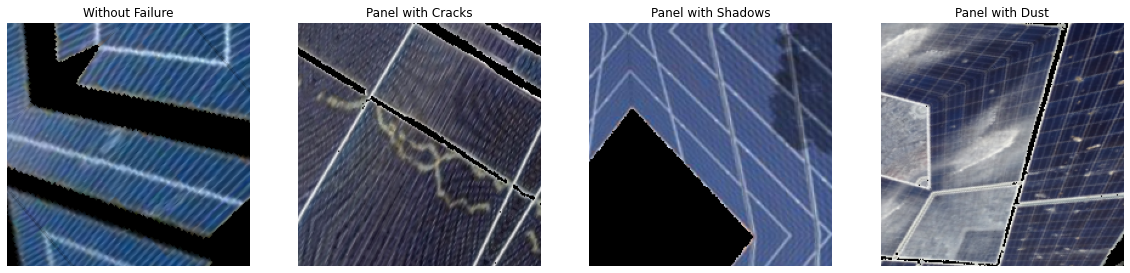

In [11]:
indexes = [0, 1, 2, 3]
f, axarr = plt.subplots(1,4, figsize=(20,20))

def labels_names(argument):
    switcher = {
        0: "Without Failure",
        1: "Panel with Cracks",
        2: "Panel with Shadows",
        3: "Panel with Dust",
    }
    return switcher.get(argument, "Invalid month")

for i in indexes:
    current_list = X_train[np.argmax(Y_train,axis=1)==i]
    axarr[i].axis('off')
    index = np.random.randint(len(current_list))
    axarr[i].imshow(current_list[index])
    axarr[i].set_title(labels_names(i))
    

## Loading VGG16 for Transfer Learning

Para este caso en particular, utilizaremos un modelo pre-entrenado que corresponde al VGG16. VGG16 es conformada por múltiples capas convolucionales y fue propuesta por K. Simonyan y A. Zisserman en la Universidad de Oxford en el paper titulado “Very Deep Convolutional Networks for Large-Scale Image Recognition”. Más información al respecto se puede encontrar visitando la siguiente página: https://neurohive.io/en/popular-networks/vgg16/. El objetivo de utilizar un modelo pre-entrenado en Machine Learning se justifica cuando se tienen pocas imágenes con las cuales se  puede entrenar y se quieren aprovechar modelos que fueron entrenados con muchas imágenes para facilitar la extracción de características. Completando la siguiente actividad y ejecutando la celda, podrán ver como está compuesta la arquitectura de este modelo.

In [12]:
# Esta sección debe ser completada por ustedes, la documentación para entender como funciona VGG16 con 
# la librearía tensorflow se puede encontrar a continuación: https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16
# únicamente deben completar el atributo input shape

pre_trained_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
pre_trained_model.trainable = False
pre_trained_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

## Entrenamiento
Como pueden ver en la anterior celda, las capas de VGG16 únicamente están compuestas por redes convolucionales y de max pooling. Este tipo de capas son principalmente utilizadas para extraer características de las imagenes por medio de relaciones entre pixeles. Con ello, estas capas convolucionales pueden detectar líneas verticales, horizontales, círculos, cuadrados, etc que pueden ayudarle a identificar el objetivo. Un ejemplo de ello se puede ver a continuación:

![picture](https://drive.google.com/uc?export=view&id=1J4SZ5qUXdpLmxOAXjRaH69vluG0rtNmf)

A partir de lo que se obtiene de las capas convolucionales, falta darle una interpretación a estas carácteristicas obtenidas. Para ello, utilizamos redes neuronales que, asi como las neuronas hacen en el cerebro, se encargan de interpretar las características obtenidas y tratar de predecir alguna categoría. En la siguiente sección, deberán agregar cuatro capas al modelo VGG16. Las capas deben ser las siguientes:

1. Debe anexar una primera capa llamada Flatten encargada de aplanar el arreglo de características para luego introducirla en las capas neuronales.
2. Anexe una capa oculta con redes neuronas con 521 neuronas y activación relu. Esta capa es la encargada de interpretar características de las imagenes mediante la siguiente operación:
$$
output = activation(dot(input, kernel) + bias)
$$
    Para más información de como implementarlo refierase a https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
    
3. Anexe una capa de tipo Dropout con un ratio de 0.2. Esto se encarga ayuda al entrenamiento a no sesgar el entrenamiento. Para más información refierase a https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout.
4. Por último, anexe una capa de redes neuronales con activación softmax con 4 neuronas, esta será la encargada de generar la etiqueta que el modelo le asigna a una imagen en particular.

Para más detalles de como implementar estas capas, pueden dirigirse a este link: https://www.tensorflow.org/api_docs/python/tf/keras/layers

In [18]:
last_output = pre_trained_model.output

# Implemente su código aquí

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4, activation = 'softmax')(x)

# Termine su código aquí


model = Model(pre_trained_model.input, x)
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['acc'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

El entrenamiento del modelo se realiza a continuación, debe completar aquellos puntos que se le indican para poder ejecutar la celda. Al ejecutar el entrenamiento, verá como el porcentaje de aciertos del modelo por sobre los datos de validación y de entrenamiento irá aumentando. A su vez, el loss function que representa que tan alejadas están las predicciones del valor verdadero, irá disminuyendo. Esto indica que el modelo efectivamente está aprendiendo.

In [19]:
history = model.fit(X_train, #aquí debe ubicar las imagenes de entrenamiento
                    Y_train, #aquí debe ubicar las etiquetas de entrenamiento
                    validation_data = (X_test, Y_test), # aquí debe ubicar las imágenes de validación y sus etiquetas
                    batch_size=30,
                    epochs=22) # aquí debe ubicar el número de iteraciones que desea que entrene (10)

Epoch 1/22
123/123 [==============================] - 36s 282ms/step - loss: 5.7503 - acc: 0.6185 - val_loss: 0.5639 - val_acc: 0.7789
Epoch 2/22
123/123 [==============================] - 33s 267ms/step - loss: 0.4294 - acc: 0.8304 - val_loss: 0.4316 - val_acc: 0.8428
Epoch 3/22
123/123 [==============================] - 33s 268ms/step - loss: 0.2389 - acc: 0.9096 - val_loss: 0.3556 - val_acc: 0.8649
Epoch 4/22
123/123 [==============================] - 33s 268ms/step - loss: 0.1416 - acc: 0.9492 - val_loss: 0.4315 - val_acc: 0.8624
Epoch 5/22
123/123 [==============================] - 33s 267ms/step - loss: 0.1357 - acc: 0.9533 - val_loss: 0.4760 - val_acc: 0.8354
Epoch 6/22
123/123 [==============================] - 33s 268ms/step - loss: 0.1176 - acc: 0.9610 - val_loss: 0.5405 - val_acc: 0.8526
Epoch 7/22
123/123 [==============================] - 33s 267ms/step - loss: 0.1310 - acc: 0.9607 - val_loss: 0.4906 - val_acc: 0.8796
Epoch 8/22
123/123 [==============================] - 3

## Plotting
A continuación se realizan gráficas del entrenamiento realizado, como pueden ver, a medida que aumentan las épocas o iteraciones del modelo, este va aumentando su porcentaje de acierto por sobre los datos de entrenamiento y validación, y el valor del loss function va disminuyendo. Esto implica que el modelo efectivamente está aprendiendo.

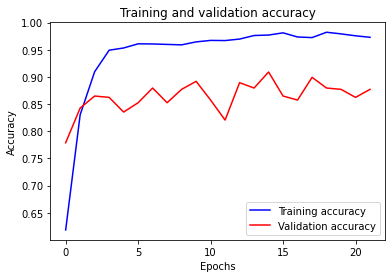

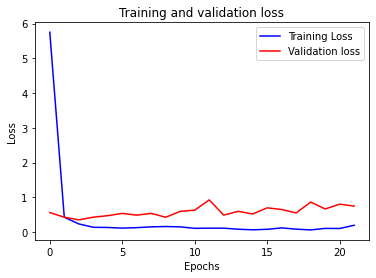

In [20]:
def plot(history):
    acc = history.history['acc']
    acc_validation = history.history['val_acc']
    loss = history.history['loss']
    loss_validation = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'b', label = 'Training accuracy')
    plt.plot(epochs, acc_validation, 'r', label = 'Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, loss_validation, 'r', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
plot(history)

## Plot Confussion Matrix

También podemos ver la matriz de confusión, este indica el número de aciertos para cada una de las clases, como podemos ver, el mayor porcentaje de confusión se encuentra en la clase sin fallos que la suele confundir con cuando el panel tiene polvo.

In [23]:
def graficarMatrizConfusion(y_true, y_pred):
    labels = ['Cracks', 'Shadows', 'Dust', 'WF']

    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') #/ cm.sum(axis=1)[:, np.newaxis]  

    fig = plt.figure(figsize=(8,8))

    ax = sns.heatmap(cm, annot = True, cbar = True);
      
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xticklabels(labels)
    ax.set_yticks([0.5, 1.5, 2.5, 3.5])
    ax.set_yticklabels(labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confussion Matrix")
    #plt.savefig(str(os.path.dirname(os.path.abspath('')))+ '/img/Confussion_matrix.png')
    plt.show()

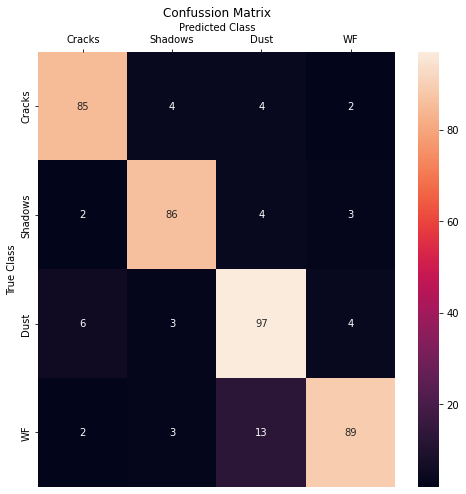

In [24]:
graficarMatrizConfusion(y_true = np.argmax(Y_test, axis = 1), y_pred = np.argmax(model.predict(X_test),axis=1))

## Save Created Model

In [25]:
#models_folder = os.path.dirname(os.path.dirname(os.path.abspath(''))) + "\\models"
models_folder = 'models/'
model.save('models/transfer_learning_quat_classification_model.h5')

## Export Model to TensorFlow Lite

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmprwp1o61n/assets


In [28]:
with open('models/model.tflite', 'wb') as f:
  f.write(tflite_model)